In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 读取两个CSV文件
mod_df = pd.read_csv('特征和密度结果_MODIS_MOD09GA_061_20241029_插值填充3.csv')
mcd_df = pd.read_csv('特征和密度结果_MODIS_MCD18C2_061_20241027_插值填充.csv')

# 重命名MCD数据框中的密度列,以区分来源
mcd_df = mcd_df.rename(columns={
    'density_mean': 'density_mean_mcd',
    'density_lower': 'density_lower_mcd', 
    'density_upper': 'density_upper_mcd'
})

# 重命名MOD数据框中的密度列
mod_df = mod_df.rename(columns={
    'density_mean': 'density_mean_mod',
    'density_lower': 'density_lower_mod',
    'density_upper': 'density_upper_mod'
})

# 合并两个数据框,以date为键
merged_df = pd.merge(mod_df, mcd_df, on='date')

# 计算两个来源的平均值作为最终密度值
merged_df['density_mean'] = merged_df['density_mean_mod']
merged_df['density_lower'] = merged_df['density_lower_mod']
merged_df['density_upper'] = merged_df['density_upper_mod']


In [2]:
pip install keras-tcn  -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


## 模型1.0版本

In [4]:
# 将日期列转换为datetime类型
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 定义特征列
features = ['ndci', 'ndvi', 'evi', 'FAI', 'nrfi', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
           'GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 'GMT_1200_PAR',
           'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR', 'DAPAR', 'PDVI', 'MPAR', 'APAR',
           'PPDI', 'PAI']

# 定义目标变量
targets = ['density_mean', 'density_lower', 'density_upper']

# 按日期划分训练集和测试集
train_df = merged_df[merged_df['date'] <= '2023-12-31']
test_df = merged_df[merged_df['date'] >= '2024-01-01']

# 准备序列数据
def create_sequences(data, features, seq_length=15):
    X, y = [], []
    feature_data = data[features].values
    target_data = data[targets].values
    
    for i in range(len(data) - seq_length):
        X.append(feature_data[i:(i + seq_length)])
        y.append(target_data[i + seq_length])
    return np.array(X), np.array(y)

# 准备训练集和测试集序列数据
seq_length = 15  # 15天的序列长度
X_train, y_train = create_sequences(train_df, features, seq_length)
X_test, y_test = create_sequences(test_df, features, seq_length)

# 导入必要的库
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LayerNormalization, Dropout, Dense, Input, Add, Activation
from tensorflow.keras.models import Model

def residual_block(x, dilation_rate, n_filters, kernel_size):
    # 残差分支
    r = Conv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    r = LayerNormalization()(r)
    r = Activation('relu')(r)
    r = Dropout(0.2)(r)
    
    r = Conv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(r)
    r = LayerNormalization()(r)
    r = Activation('relu')(r)
    r = Dropout(0.2)(r)
    
    # 如果输入和输出维度不同,使用1x1卷积进行调整
    if x.shape[-1] != n_filters:
        x = Conv1D(n_filters, 1, padding='same')(x)
        
    return Add()([x, r])

# 构建TCN模型
input_layer = Input(shape=(seq_length, len(features)))
x = input_layer

# TCN层
n_filters = 64
kernel_size = 3
dilations = [1, 2, 4, 8, 16, 32]

for d in dilations:
    x = residual_block(x, d, n_filters, kernel_size)

# 只取最后一个时间步
x = tf.keras.layers.Lambda(lambda x: x[:, -1, :])(x)

# 输出层
output_layer = Dense(3)(x)

# 创建模型
model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
model.compile(
    optimizer='adam',
    loss='mse'
)

# 训练模型
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 预测
predictions = model.predict(X_test)
y_mean_pred = predictions[:, 0]
y_lower_pred = predictions[:, 1] 
y_upper_pred = predictions[:, 2]


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 3403024189882368.0000 - val_loss: 246410226171904.0000
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 253268970176512.0000 - val_loss: 219748126162944.0000
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 248806448824320.0000 - val_loss: 213896468103168.0000
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 217339924578304.0000 - val_loss: 213112871452672.0000
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 236562268815360.0000 - val_loss: 243189386575872.0000
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 238092921339904.0000 - val_loss: 201509430099968.0000
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 185674640654336.0000 - val_loss: 200663539646464.0000
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 202662075170816.0000 - val_loss: 216872662335488.0000
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 186063435857920.0000 - val_loss: 

## 模型2.0版本（更加平滑）
（增加序列长度，增加滤波器数量，增加卷积核大小，增加扩张率，增加dropout率，增加epochs，增加batch size，添加早停）

In [2]:
# 将日期列转换为datetime类型
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 定义特征列
features = ['ndci', 'ndvi', 'evi', 'FAI', 'nrfi', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
           'GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 'GMT_1200_PAR',
           'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR', 'DAPAR', 'PDVI', 'MPAR', 'APAR',
           'PPDI', 'PAI']

# 定义目标变量
targets = ['density_mean', 'density_lower', 'density_upper']

# 按日期划分训练集和测试集
train_df = merged_df[merged_df['date'] <= '2023-12-31']
test_df = merged_df[merged_df['date'] >= '2024-01-01']

# 准备序列数据
def create_sequences(data, features, seq_length=30):  # 增加序列长度到30
    X, y = [], []
    feature_data = data[features].values
    target_data = data[targets].values
    
    for i in range(len(data) - seq_length):
        X.append(feature_data[i:(i + seq_length)])
        y.append(target_data[i + seq_length])
    return np.array(X), np.array(y)

# 准备训练集和测试集序列数据
seq_length = 30  # 增加到30天的序列长度
X_train, y_train = create_sequences(train_df, features, seq_length)
X_test, y_test = create_sequences(test_df, features, seq_length)

# 导入必要的库
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LayerNormalization, Dropout, Dense, Input, Add, Activation
from tensorflow.keras.models import Model

def residual_block(x, dilation_rate, n_filters, kernel_size):
    # 增加dropout率以减少过拟合
    dropout_rate = 0.3
    
    # 残差分支
    r = Conv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    r = LayerNormalization()(r)
    r = Activation('elu')(r)  # 使用elu激活函数替代relu
    r = Dropout(dropout_rate)(r)
    
    r = Conv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(r)
    r = LayerNormalization()(r)
    r = Activation('elu')(r)  # 使用elu激活函数替代relu
    r = Dropout(dropout_rate)(r)
    
    # 如果输入和输出维度不同,使用1x1卷积进行调整
    if x.shape[-1] != n_filters:
        x = Conv1D(n_filters, 1, padding='same')(x)
        
    return Add()([x, r])

# 构建TCN模型
input_layer = Input(shape=(seq_length, len(features)))
x = input_layer

# TCN层 - 增加滤波器数量和扩张率
n_filters = 128  # 增加滤波器数量
kernel_size = 5  # 增加卷积核大小
dilations = [1, 2, 4, 8, 16, 32, 64]  # 增加扩张率序列

for d in dilations:
    x = residual_block(x, d, n_filters, kernel_size)

# 只取最后一个时间步
x = tf.keras.layers.Lambda(lambda x: x[:, -1, :])(x)

# 添加额外的密集层来增加平滑性
x = Dense(64, activation='elu')(x)
x = Dropout(0.3)(x)

# 输出层
output_layer = Dense(3)(x)

# 创建模型
model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型 - 使用更小的学习率
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='mse'
)

# 训练模型 - 增加epochs并添加早停
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,  # 增加训练轮数
    batch_size=64,  # 增加batch size
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 预测
predictions = model.predict(X_test)
y_mean_pred = predictions[:, 0]
y_lower_pred = predictions[:, 1] 
y_upper_pred = predictions[:, 2]


2024-10-30 22:36:26.188728: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 22:36:26.226116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 22:36:26.252889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 22:36:26.260671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 22:36:26.283951: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 520ms/step - loss: 2464598800203776.0000 - val_loss: 257620829011968.0000
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - loss: 702611820904448.0000 - val_loss: 173766961266688.0000
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 493ms/step - loss: 470397166288896.0000 - val_loss: 269886567743488.0000
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - loss: 400496238002176.0000 - val_loss: 290634464231424.0000
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 470ms/step - loss: 311151254568960.0000 - val_loss: 235568554311680.0000
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 460ms/step - loss: 306225061298176.0000 - val_loss: 248735279874048.0000
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - loss: 252492604506112.0000 - val_loss: 245533197205504.0000
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 436ms/step - loss: 278179595943936.0000 - val_loss: 245012432420864.0000
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 450ms/step - loss: 241834324393984.0

## 模型3.0版本（更加平滑）
（增加序列长度，增加滤波器数量，增加卷积核大小，增加扩张率，增加dropout率，增加epochs，增加batch size，添加早停，添加elu激活函数）

In [4]:
# 将日期列转换为datetime类型
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 定义特征列
features = ['ndci', 'ndvi', 'evi', 'FAI', 'nrfi', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
           'GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 'GMT_1200_PAR',
           'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR', 'DAPAR', 'PDVI', 'MPAR', 'APAR',
           'PPDI', 'PAI']

# 定义目标变量
targets = ['density_mean', 'density_lower', 'density_upper']

# 按日期划分训练集和测试集
train_df = merged_df[merged_df['date'] <= '2023-12-31']
test_df = merged_df[merged_df['date'] >= '2024-01-01']

# 准备序列数据
def create_sequences(data, features, seq_length=15):  # 进一步增加序列长度到45
    X, y = [], []
    feature_data = data[features].values
    target_data = data[targets].values
    
    for i in range(len(data) - seq_length):
        X.append(feature_data[i:(i + seq_length)])
        y.append(target_data[i + seq_length])
    return np.array(X), np.array(y)

# 准备训练集和测试集序列数据
seq_length = 15  # 增加到45天的序列长度
X_train, y_train = create_sequences(train_df, features, seq_length)
X_test, y_test = create_sequences(test_df, features, seq_length)

# 导入必要的库
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LayerNormalization, Dropout, Dense, Input, Add, Activation
from tensorflow.keras.models import Model

def residual_block(x, dilation_rate, n_filters, kernel_size):
    # 增加dropout率以进一步减少过拟合
    dropout_rate = 0.4
    
    # 残差分支
    r = Conv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    r = LayerNormalization()(r)
    r = Activation('selu')(r)  # 使用selu激活函数以获得更好的平滑性
    r = Dropout(dropout_rate)(r)
    
    r = Conv1D(n_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(r)
    r = LayerNormalization()(r)
    r = Activation('selu')(r)  # 使用selu激活函数
    r = Dropout(dropout_rate)(r)
    
    # 如果输入和输出维度不同,使用1x1卷积进行调整
    if x.shape[-1] != n_filters:
        x = Conv1D(n_filters, 1, padding='same')(x)
        
    return Add()([x, r])

# 构建TCN模型
input_layer = Input(shape=(seq_length, len(features)))
x = input_layer

# TCN层 - 进一步增加滤波器数量和扩张率
n_filters = 256  # 增加滤波器数量到256
kernel_size = 7  # 增加卷积核大小到7
dilations = [1, 2, 4, 8, 16, 32, 64, 128]  # 增加扩张率序列

for d in dilations:
    x = residual_block(x, d, n_filters, kernel_size)

# 只取最后一个时间步
x = tf.keras.layers.Lambda(lambda x: x[:, -1, :])(x)

# 添加更多的密集层来增加平滑性
x = Dense(128, activation='selu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='selu')(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='selu')(x)
x = Dropout(0.4)(x)

# 输出层
output_layer = Dense(3, activation='linear')(x)

# 创建模型
model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型 - 使用更小的学习率
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)  # 进一步降低学习率
model.compile(
    optimizer=optimizer,
    loss='mse'
)

# 训练模型 - 增加epochs和patience
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,  # 增加patience
    restore_best_weights=True
)

# 添加学习率衰减
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001
)

history = model.fit(
    X_train, y_train,
    epochs=200,  # 增加训练轮数到200
    batch_size=32,  # 减小batch size以增加稳定性
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 预测
predictions = model.predict(X_test)
y_mean_pred = predictions[:, 0]
y_lower_pred = predictions[:, 1] 
y_upper_pred = predictions[:, 2]


Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 1136703360204800.0000 - val_loss: 460448981843968.0000 - learning_rate: 2.0000e-04
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 464135573733376.0000 - val_loss: 454146050228224.0000 - learning_rate: 2.0000e-04
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 381227538317312.0000 - val_loss: 422653303193600.0000 - learning_rate: 2.0000e-04
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 329394530811904.0000 - val_loss: 439996448243712.0000 - learning_rate: 2.0000e-04
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 307253169094656.0000 - val_loss: 412034432761856.0000 - learning_rate: 2.0000e-04
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 428285213278208.0000 - val_loss: 430533393776640.0000 - learning_rate: 2.0000e-04
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 296429851508736.0000 - val_loss: 385092572676096.0000 - learning_rate: 2.0000e-04
Epoch 8/200


/tmp/ipykernel_11833/3724871750.py:23: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/3724871750.py:23: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/3724871750.py:23: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/3724871750.py:23: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/3724871750.py:23: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/3724871750.py:23: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/3724871750.py:23: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  plt.

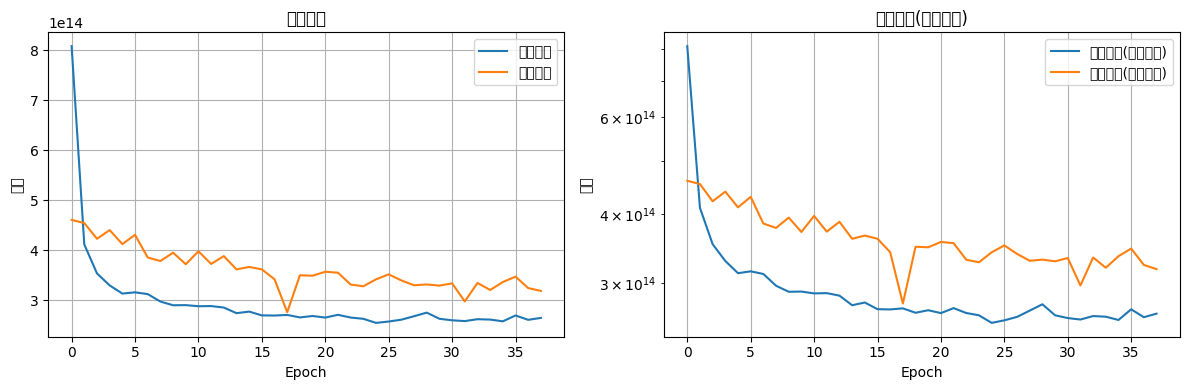


最终训练损失: 264184998658048.000000
最终验证损失: 318235266252800.000000
最佳验证损失: 275638569140224.000000


In [6]:

# 绘制训练历史
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('模型损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='训练损失(对数尺度)')
plt.plot(history.history['val_loss'], label='验证损失(对数尺度)')
plt.yscale('log')
plt.title('模型损失(对数尺度)')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 打印最终的训练和验证损失
print(f"\n最终训练损失: {history.history['loss'][-1]:.6f}")
print(f"最终验证损失: {history.history['val_loss'][-1]:.6f}")
print(f"最佳验证损失: {min(history.history['val_loss']):.6f}")



R2 分数:
平均密度: -3.3771
下限密度: -3.5093
上限密度: -3.3713


/tmp/ipykernel_11833/891806621.py:38: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/891806621.py:38: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/891806621.py:38: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/891806621.py:38: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/891806621.py:38: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/891806621.py:38: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11833/891806621.py:38: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_l

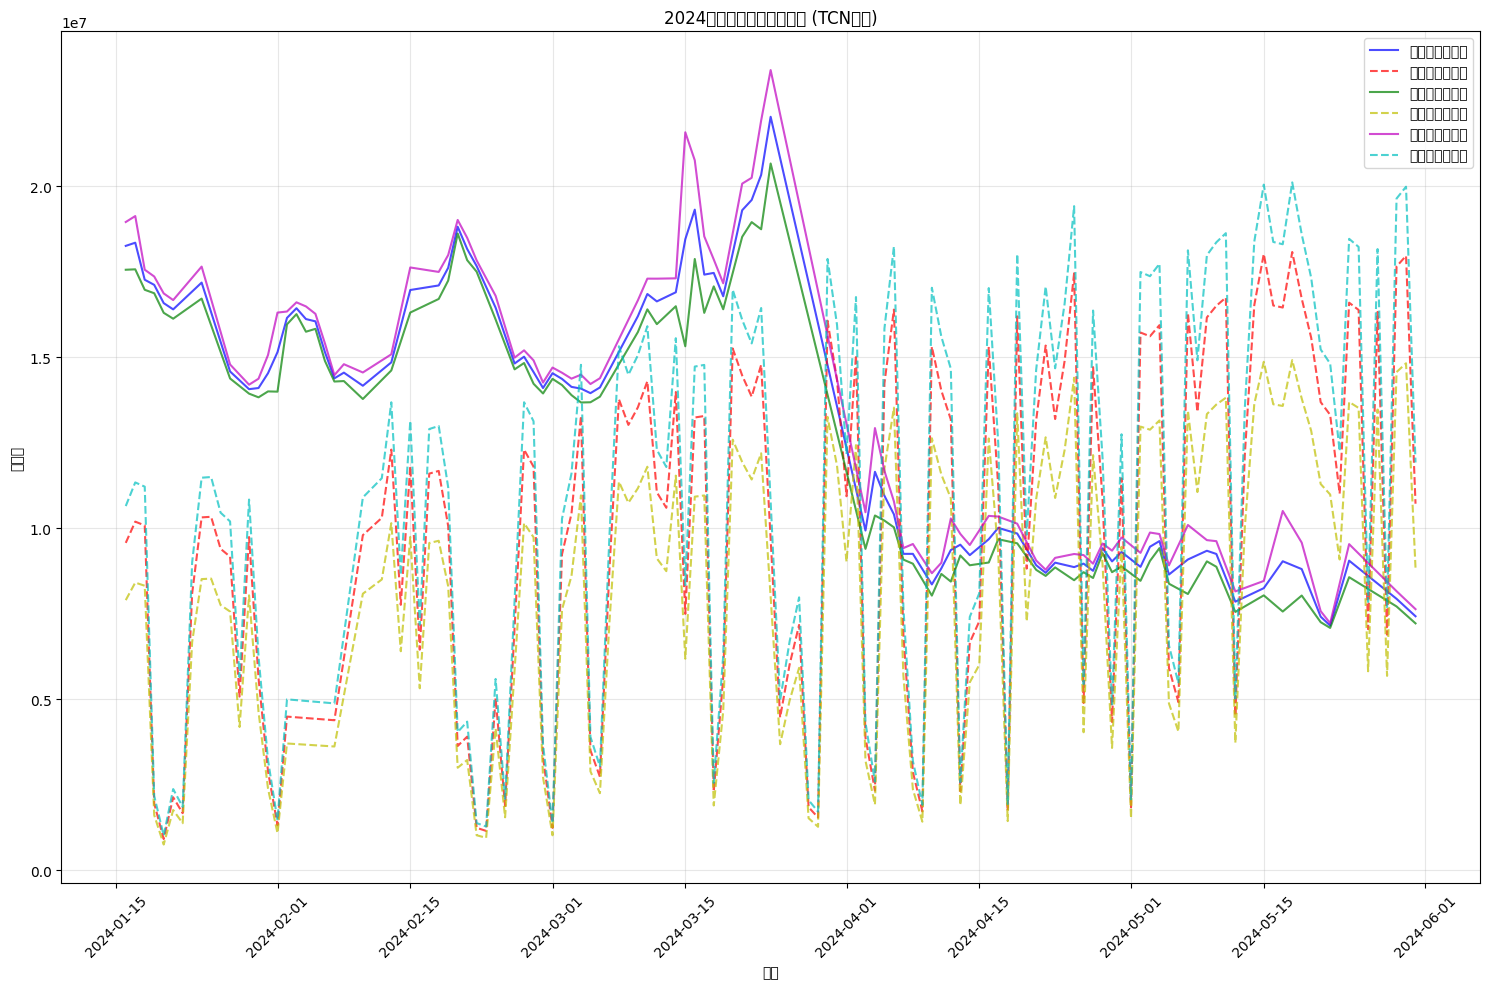

In [5]:

# 计算R2分数
r2_mean = r2_score(y_test[:, 0], y_mean_pred)
r2_lower = r2_score(y_test[:, 1], y_lower_pred)
r2_upper = r2_score(y_test[:, 2], y_upper_pred)

print("\nR2 分数:")
print(f"平均密度: {r2_mean:.4f}")
print(f"下限密度: {r2_lower:.4f}")
print(f"上限密度: {r2_upper:.4f}")

# 绘制测试集的预测结果
plt.figure(figsize=(15, 10))

# 调整日期索引以匹配序列预测结果
test_dates = test_df['date'].iloc[seq_length:]

# 绘制实际值和预测值
plt.plot(test_dates, y_test[:, 0], 'b-', label='平均密度实际值', alpha=0.7)
plt.plot(test_dates, y_mean_pred, 'r--', label='平均密度预测值', alpha=0.7)
plt.plot(test_dates, y_test[:, 1], 'g-', label='下限密度实际值', alpha=0.7)
plt.plot(test_dates, y_lower_pred, 'y--', label='下限密度预测值', alpha=0.7)
plt.plot(test_dates, y_test[:, 2], 'm-', label='上限密度实际值', alpha=0.7)
plt.plot(test_dates, y_upper_pred, 'c--', label='上限密度预测值', alpha=0.7)

# 添加标题和标签
plt.title('2024年藻密度预测结果对比 (TCN模型)')
plt.xlabel('日期')
plt.ylabel('藻密度')
plt.legend()

# 旋转x轴日期标签以提高可读性
plt.xticks(rotation=45)

# 显示网格
plt.grid(True, alpha=0.3)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()